## Project Title: Recommending Music Based on Emotions through AI-Infused Convolutional Neural Networks

### Project Description

In this project, we aim to create a novel music recommendation system that harnesses AI-Infused Convolutional Neural Networks (CNNs) to provide personalized music suggestions based on users' emotional states. Our approach relies on a rich dataset of 28,709 grayscale facial images, each measuring 48x48 pixels, and we will utilize this data to accurately detect and classify a range of emotions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The project encompasses the following critical elements:

**Emotion Detection:** We will train our AI-Infused CNNs to effectively recognize and classify emotions in real-time by analyzing facial images, ensuring a seamless user experience.

**Music Recommendation:** Building upon the detected emotions, our system will recommend music that aligns with the user's current emotional state, offering a tailored musical journey.

By converging the realms of AI and music, our project aspires to deepen the emotional connection between users and music, offering a distinctive and immersive musical experience. It promises to redefine how we interact with music and emotions through the integration of AI technology.

### Importing Libraries and Packages

In [4]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import Audio

In [6]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.14.0
Num GPUs Available:  0


### Loading Dataset

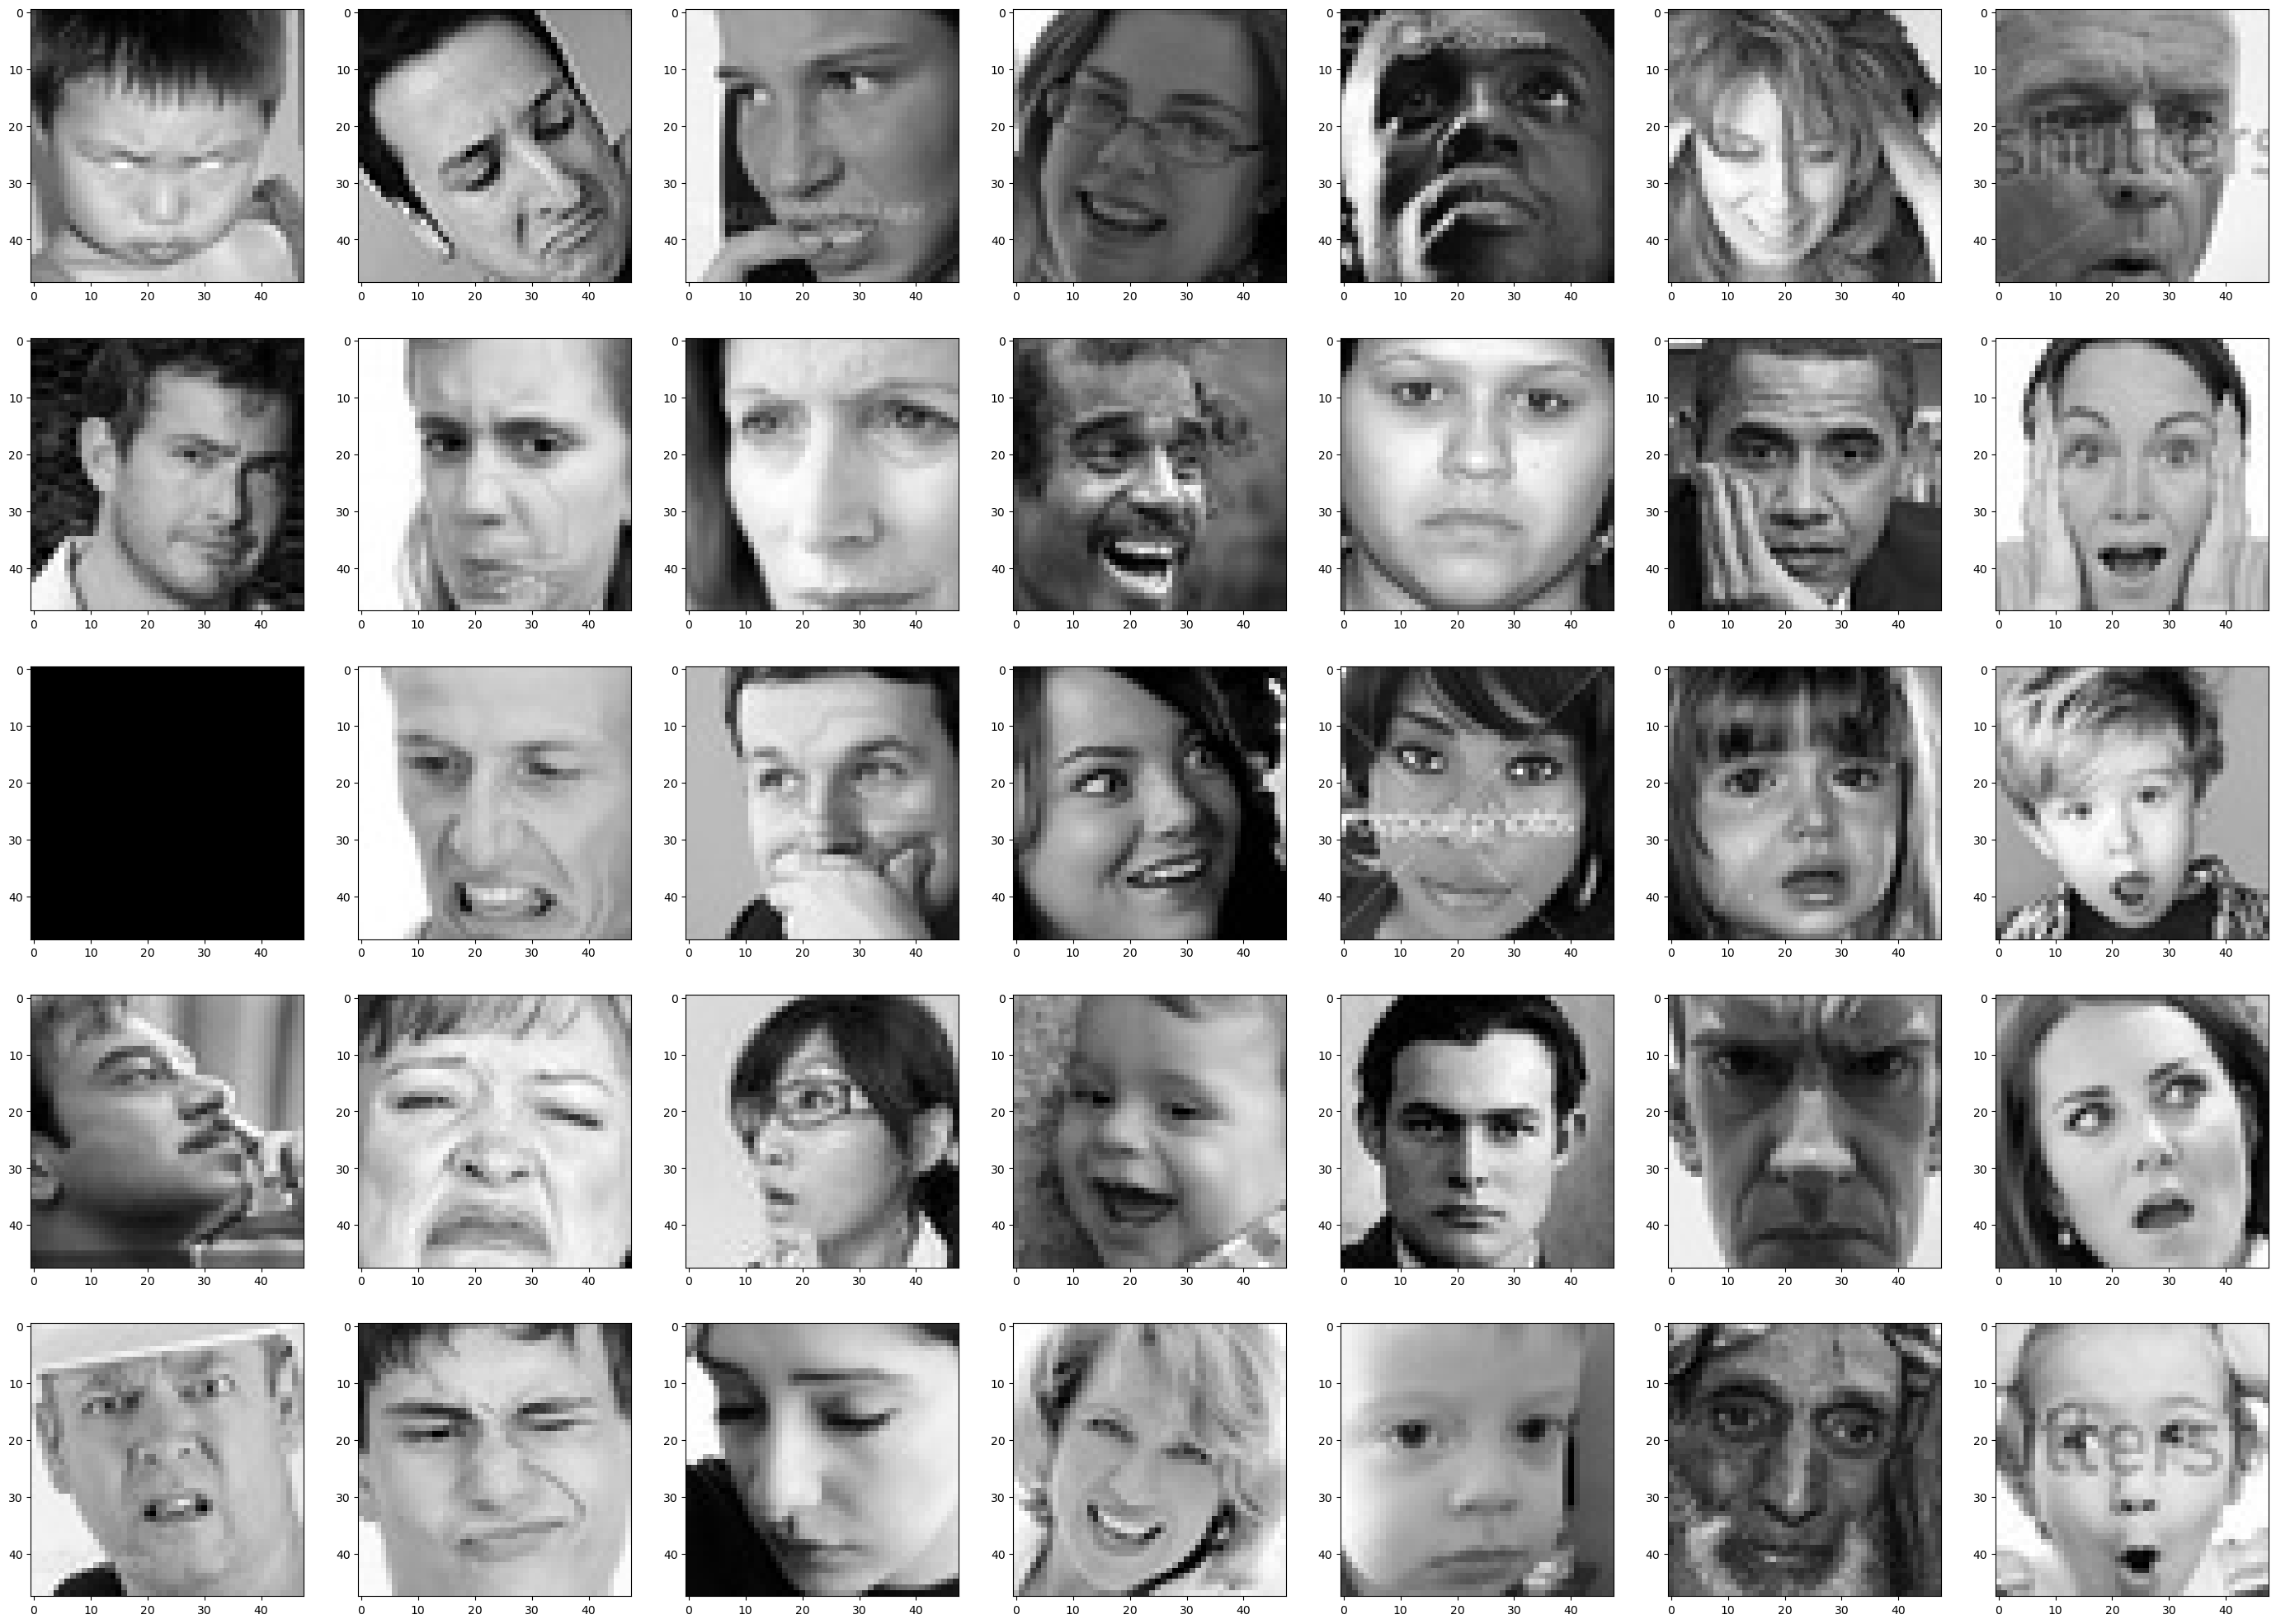

In [7]:
train_dir = r"C:\Users\ADMIN\Documents\MSc in Data Science\Facial Mood\train"
test_dir = r"C:\Users\ADMIN\Documents\MSc in Data Science\Facial Mood\test"

total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))

for x in range(5):
    for y, v in zip(range(total_labels), os.listdir(train_dir)):
        class_dir = os.path.join(train_dir, v)  # Use os.path.join to construct the path
        images_in_class = os.listdir(class_dir)
        
        if x < len(images_in_class):  # Check if there are enough images in the class
            image_path = os.path.join(class_dir, images_in_class[x])
            ax[x][y].imshow(imread(image_path), cmap='gray')

plt.show()


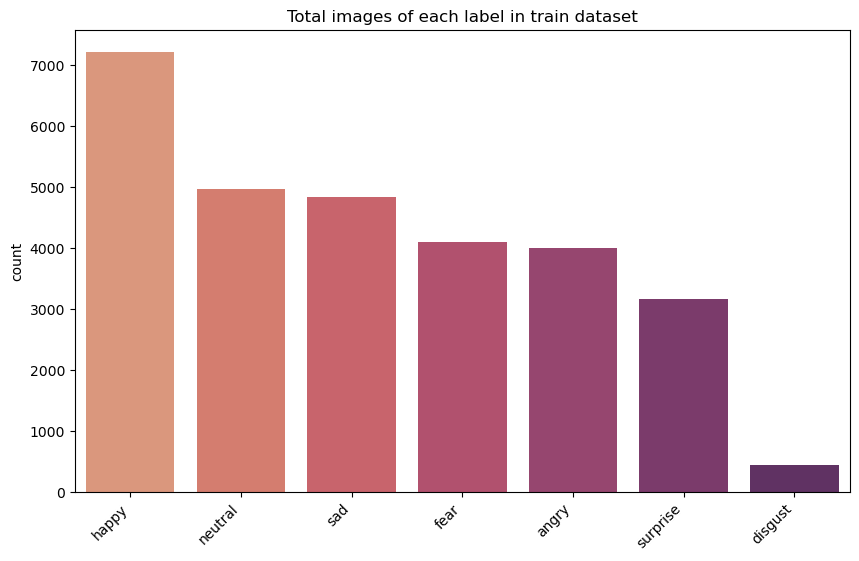

In [8]:
train_dir = r"C:\Users\ADMIN\Documents\MSc in Data Science\Facial Mood\train"

df = {}
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)  # Use os.path.join to construct the path
    df[label] = len(os.listdir(label_dir))

df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=df.index, y="total", palette="flare", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


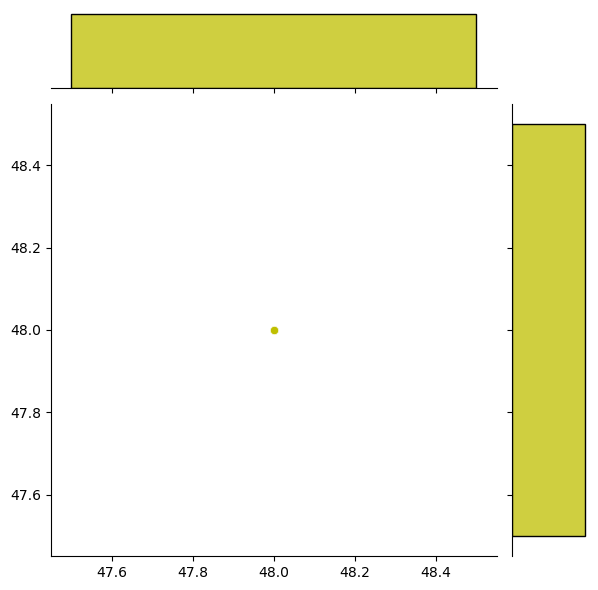

In [9]:
happy_dir = os.path.join(train_dir, 'happy')  # Use os.path.join to construct the path
happy = os.listdir(happy_dir)

dim1, dim2 = [], []

for img_filename in happy:
    img_path = os.path.join(happy_dir, img_filename)  # Use os.path.join to construct the full image path
    img = imread(img_path)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2, color='y')
plt.show()

### Data Preprocessing

In [10]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Model Building

In [11]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

### Training the Model

In [12]:
from keras.optimizers import Adam

# Train the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)


Epoch 1/20
448/448 [==============================] - 1358s 3s/step - loss: 1.8647 - accuracy: 0.2350 - val_loss: 2.6317 - val_accuracy: 0.1735
Epoch 2/20
448/448 [==============================] - 1344s 3s/step - loss: 1.7981 - accuracy: 0.2503 - val_loss: 1.8214 - val_accuracy: 0.2628
Epoch 3/20
448/448 [==============================] - 1344s 3s/step - loss: 1.7860 - accuracy: 0.2561 - val_loss: 1.7883 - val_accuracy: 0.2833
Epoch 4/20
448/448 [==============================] - 1347s 3s/step - loss: 1.7690 - accuracy: 0.2673 - val_loss: 1.6745 - val_accuracy: 0.3156
Epoch 5/20
448/448 [==============================] - 1344s 3s/step - loss: 1.7479 - accuracy: 0.2800 - val_loss: 1.6997 - val_accuracy: 0.3205
Epoch 6/20
448/448 [==============================] - 1344s 3s/step - loss: 1.7233 - accuracy: 0.3010 - val_loss: 1.8117 - val_accuracy: 0.3082
Epoch 7/20
448/448 [==============================] - 1347s 3s/step - loss: 1.6966 - accuracy: 0.3124 - val_loss: 1.8444 - val_accuracy:

In [14]:
#Model Saved
model.save("model.h5")

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 95s 837ms/step - loss: 1.2592 - accuracy: 0.5181
validation accuracy : 51.811087131500244%
validation loss : 1.2592391967773438


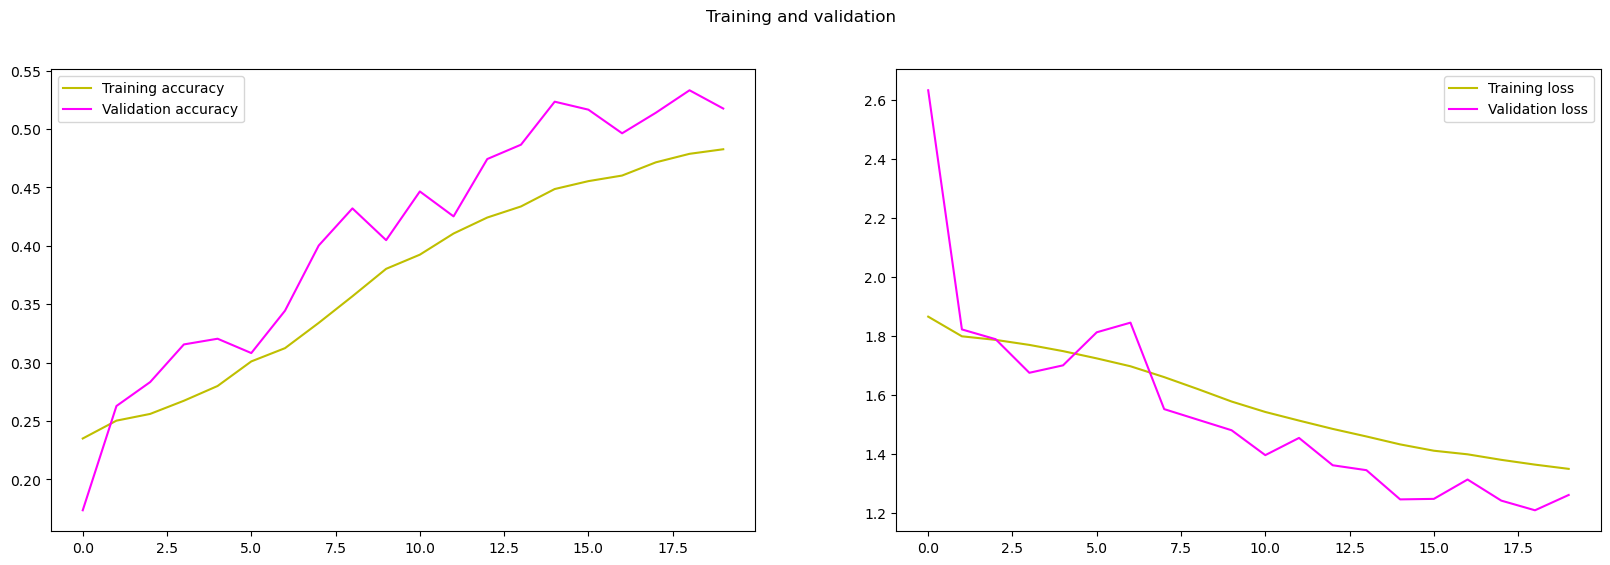

In [16]:
# Plotting Validation Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'magenta', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'magenta', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 93s 810ms/step


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.32      0.64      0.43       958
     disgust       0.00      0.00      0.00       111
        fear       0.34      0.10      0.16      1024
       happy       0.87      0.71      0.78      1774
     neutral       0.48      0.49      0.49      1233
         sad       0.44      0.39      0.41      1247
    surprise       0.57      0.79      0.66       831

    accuracy                           0.52      7178
   macro avg       0.43      0.45      0.42      7178
weighted avg       0.53      0.52      0.50      7178





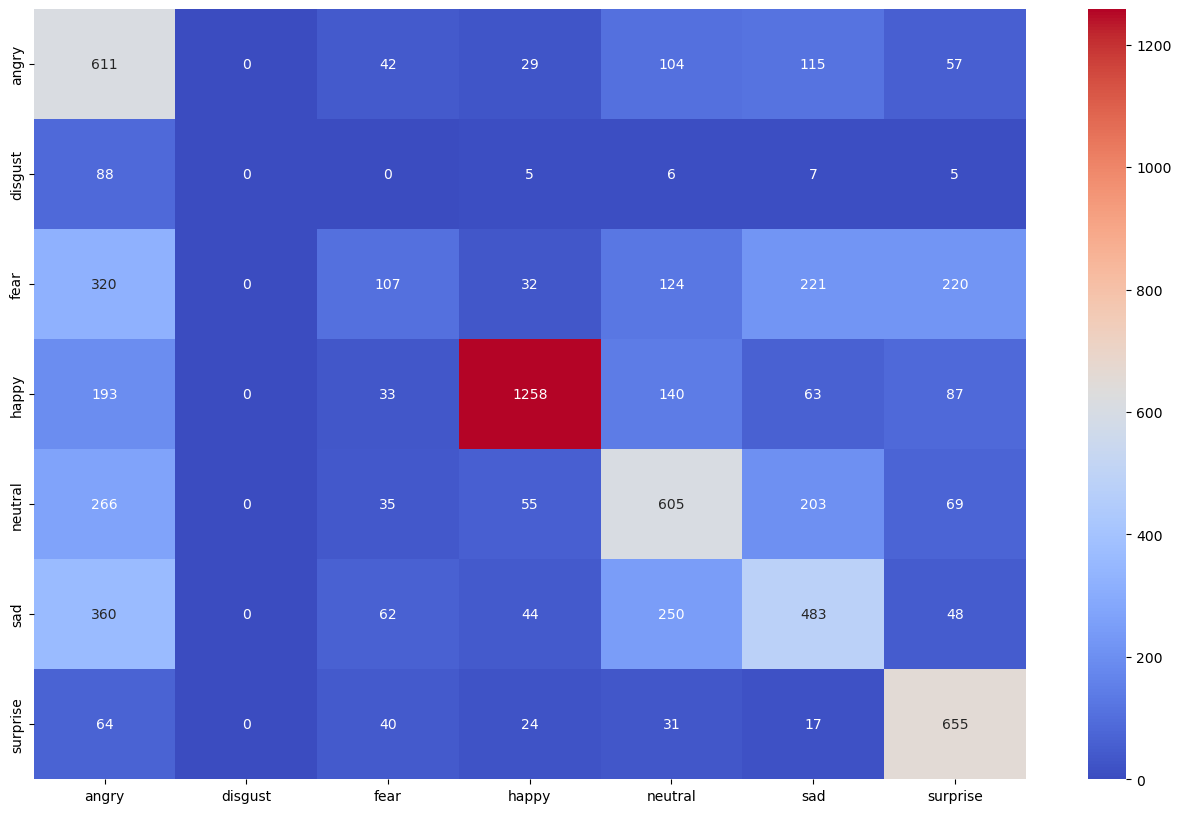

In [17]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.coolwarm, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization

# Define the custom optimizer
custom_optimizer = Adam(learning_rate=0.0001)

# Load the model with custom_objects
model = load_model("model.h5", custom_objects={'BatchNormalization': BatchNormalization, 'Adam': custom_optimizer})

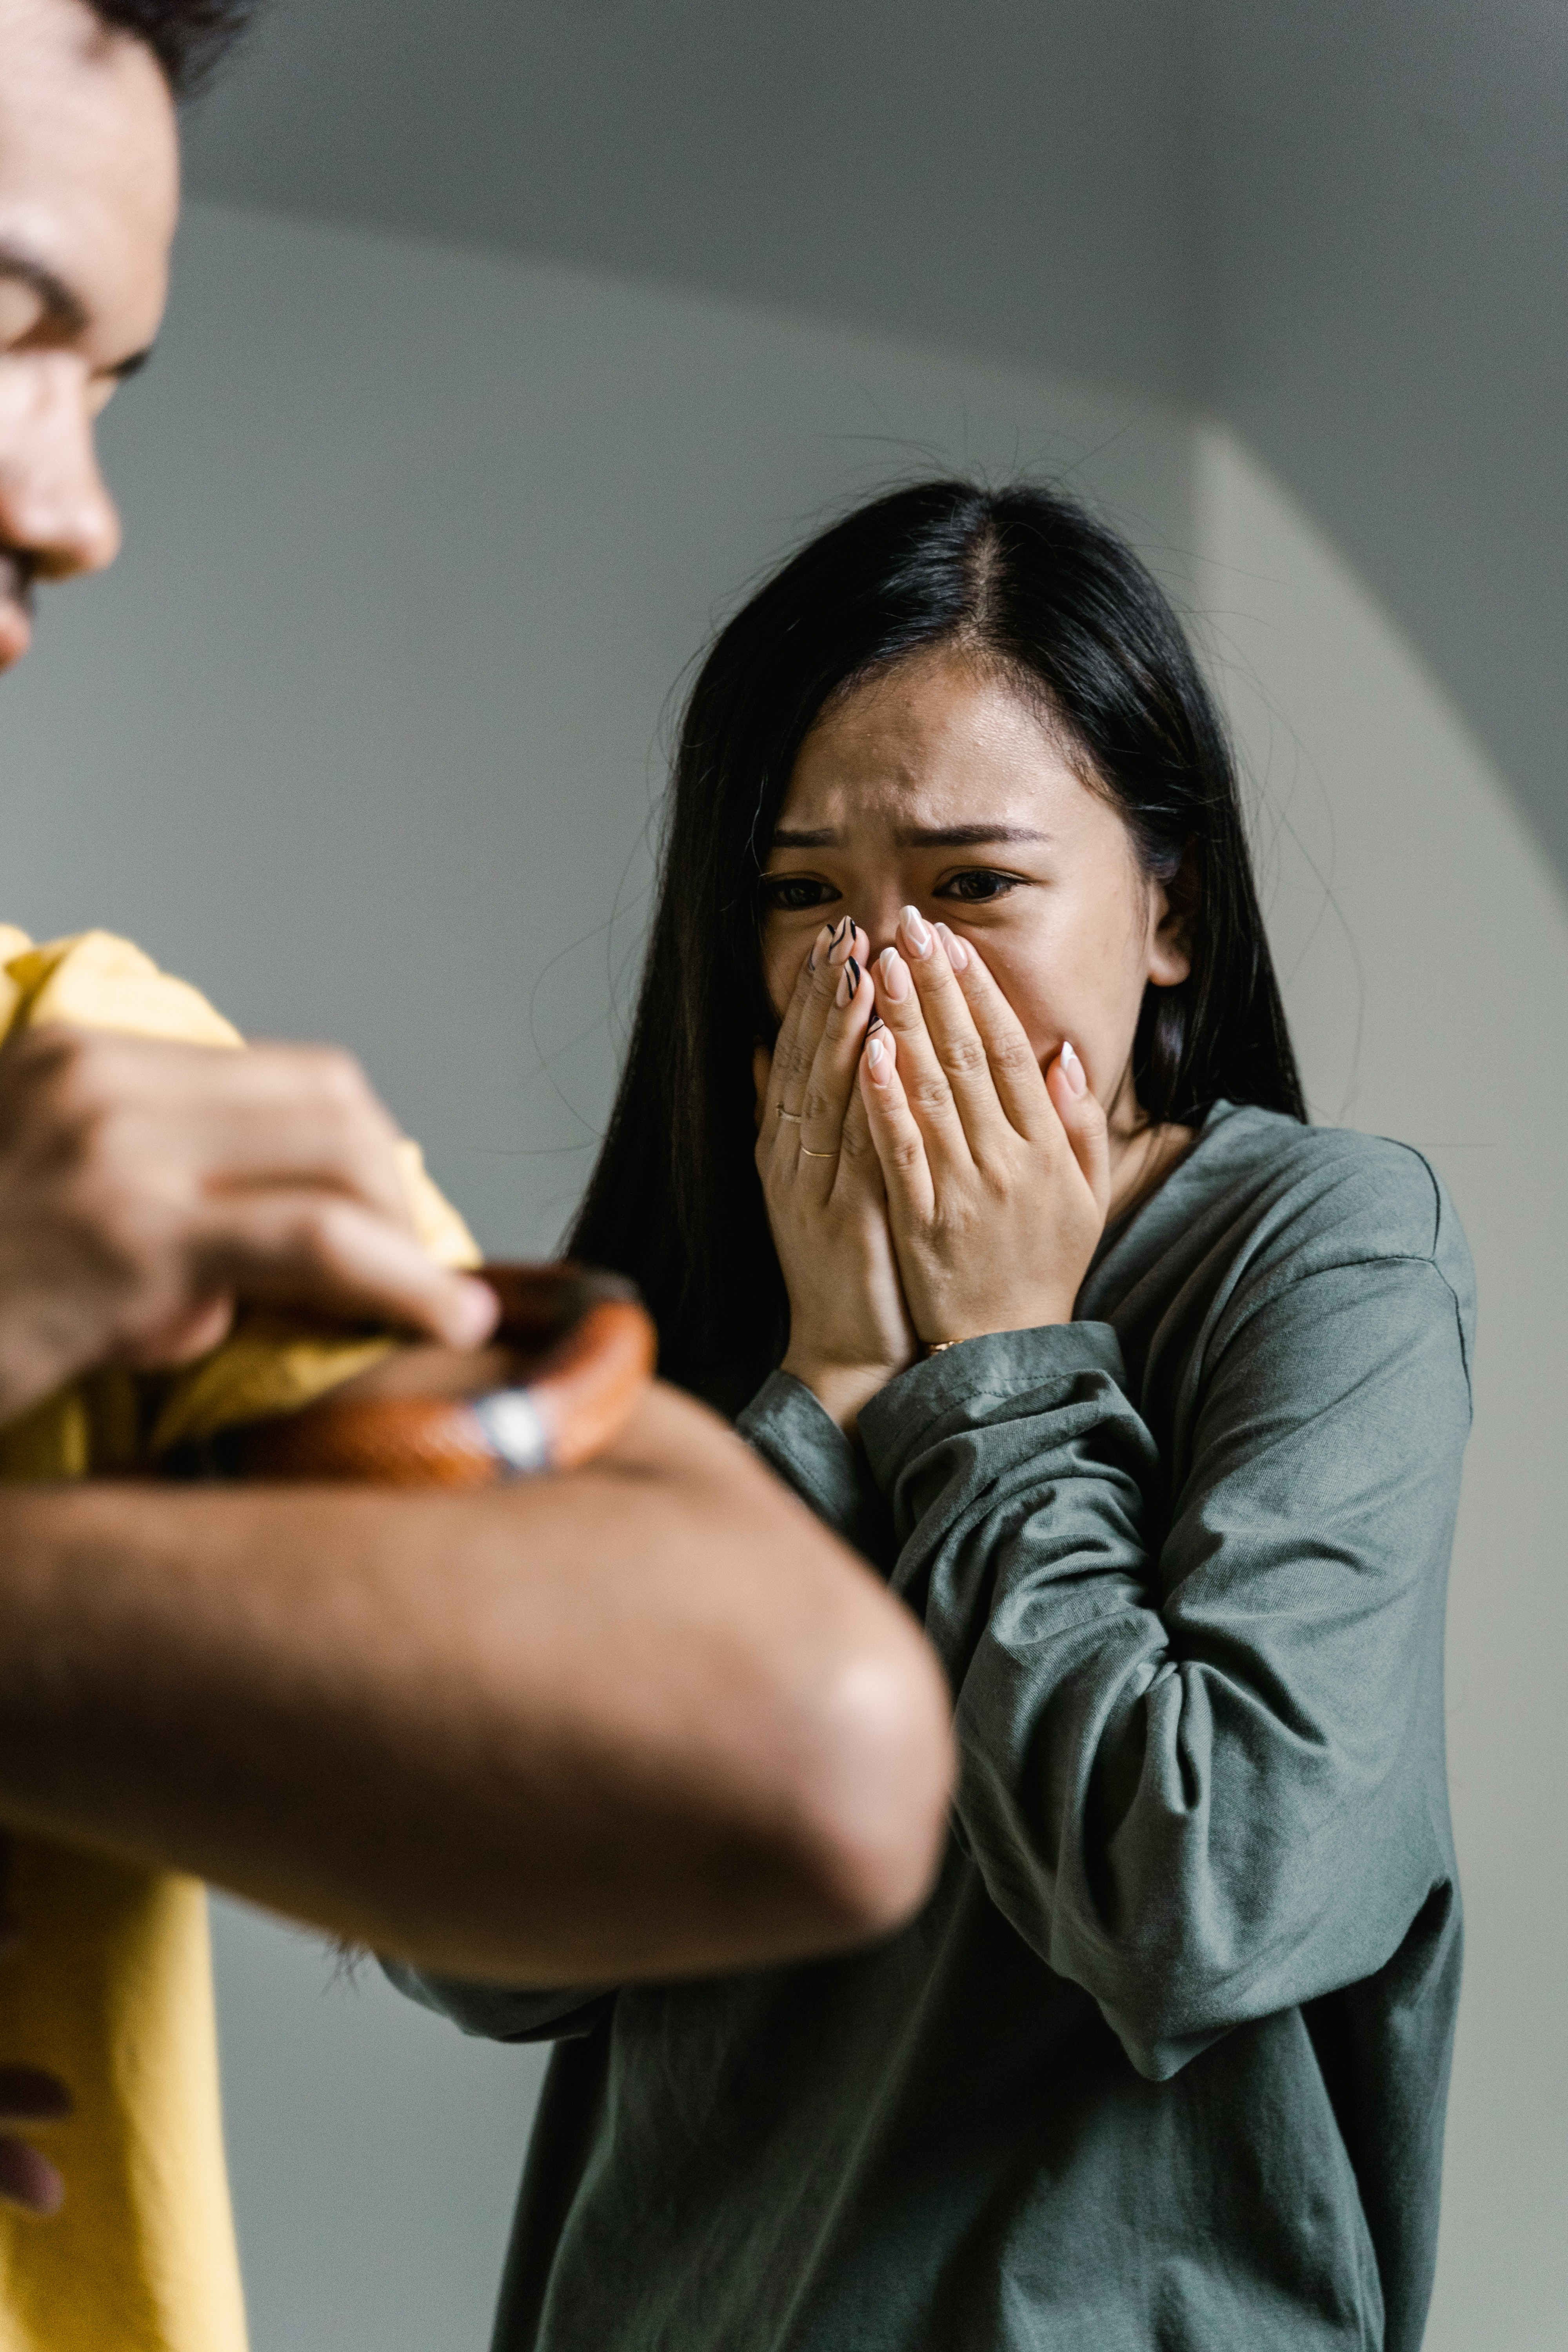

In [72]:
# Testing our model with a new image
image_path = r"C:\Users\ADMIN\Documents\MSc in Data Science\LGM INTERNSHIP\LGM INTERNSHIP\SAMPLE CODES\LGM TASK NUMBER 10\sad.jpg"
image = cv2.imread(image_path)

from IPython.display import Image
Image(filename=image_path)

In [73]:
import cv2

# Replace 'your_image_path' with the actual path to your image file
img = cv2.imread(r"C:\Users\ADMIN\Documents\MSc in Data Science\LGM INTERNSHIP\LGM INTERNSHIP\SAMPLE CODES\LGM TASK NUMBER 10\sad.jpg")

# Check if the image was read successfully
if img is None:
    print("Error: Unable to read the image. Please check the file path.")
else:
    # Rest of the code remains the same
    frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_BITS2)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0
    gray = gray.reshape(1, 48, 48, 1)

    # Output the prediction
    predicts = model.predict(gray)[0]
    label = EMOTIONS[predicts.argmax()]
    for (i, j) in zip(range(7), EMOTIONS):
        predictss = predicts[i]
        print("{:^10s}".format(j) + "prediction rate is   {0:.2f}%".format(predictss))
    print("\n\n The system considers this expression to be:", label)

1/1 [==============================] - 0s 61ms/step
  Angry   prediction rate is   0.19%
 Disgust  prediction rate is   0.00%
  Happy   prediction rate is   0.11%
   Sad    prediction rate is   0.30%
 Surprise prediction rate is   0.21%
 Neutral  prediction rate is   0.17%


 The system considers this expression to be: Sad


In [74]:
pip install pygame

Note: you may need to restart the kernel to use updated packages.


In [77]:
# Song Recommendation
if (label=='Angry'):
    path="song\\Angry\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Angry\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="song\\Disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Disgust\\'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="song\\Happy\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Happy\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="song\\Sad\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Sad\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="song\\Surprise\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Surprise\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="song\\Neutral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Neutral\\'+ d,autoplay=True)
    display(audio)

Now Playing: structure mood off.mp3


### Conclusion

In this project, the goal was to create an innovative Music Recommendation System using AI-Infused Convolutional Neural Networks (CNNs) to personalize song suggestions based on users' emotional states. The foundation of the system lies in the analysis of a dataset comprising 28,709 grayscale facial images, each measuring 48x48 pixels. The model was trained to recognize and classify seven distinct emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.

The project is structured around three core elements:

1. **Emotion Detection:**
   - A Convolutional Neural Network (CNN) was developed to accurately detect and classify real-time emotions by analyzing facial images. This step ensures a seamless user experience by providing timely and accurate emotional insights.

2. **Music Recommendation:**
   - Building upon the detected emotions, the system recommends music that aligns with the user's current emotional state. This personalized music recommendation adds a unique and emotional layer to the user's musical journey.

3. **Real-Time Adaptation:**
   - The system's ability to continuously assess the user's mood allows for dynamic, real-time adjustments in music recommendations. This feature enhances user engagement and personalization, creating a more immersive experience.

The integration of AI technology into the realm of music aims to deepen the emotional connection between users and their music choices. By fusing facial emotion analysis with personalized music suggestions, the project redefines how users interact with and experience music, promising a novel and engaging musical journey.

The technical implementation involves importing relevant libraries and packages, loading a facial emotion dataset, preprocessing the data for CNN training, building the CNN model, training the model, and evaluating its performance. The project also features a song recommendation system that leverages the trained emotion detection model to select songs based on the user's emotional state in real time.

Despite achieving a validation accuracy of around 51.81%, there is room for improvement in the model's accuracy for more precise emotion detection. Additionally, the project successfully demonstrates the seamless integration of AI technology into a music recommendation system, offering a creative and immersive experience for users.